# Metrics 

> Defines metrics to quantify circadian disruption 

In [ ]:
#| default_exp metrics

In [ ]:
#| hide 
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.basics import *
import matplotlib.pyplot as plt

In [ ]:
#| export
import numpy as np
from typing import List
from circadian.models import Hannay19
from circadian.lights import LightSchedule

In [ ]:
#| export
#| hide
def esri(time: np.ndarray, # time in hours to use for the simulation 
         light_schedule: np.ndarray, # light schedule in lux 
         analysis_days: int=4, # number of days used to calculate ESRI
         esri_dt: float=1.0, # time resolution of the ESRI calculation
         initial_amplitude: float=0.1, # initial amplitude for the simulation. This is the ESRI value for constant darkness
         phase_at_midnight: float=1.65238233, # phase at midnight. Default value corresponds to a 8 hour darkness and 16 hour light schedule with wake at 8 am.
         ) -> List: # list with ESRI timepoints and ESRI values. Negative ESRI values are turned into NaNs
        "Calculate the ESRI metric for a given light schedule. Follows the implementation from Moreno et al. 2023 'Validation of the Entrainment Signal Regularity Index and associations with children's changes in BMI'"
        # validate inputs
        if not isinstance(time, np.ndarray):
            raise TypeError(f'time must be a numpy array, not {type(time)}')
        if not isinstance(light_schedule, np.ndarray):
            raise TypeError(f'light_schedule must be a numpy array, not {type(light_schedule)}')
        if len(time) != len(light_schedule):
            raise ValueError(f'time and light_schedule must be the same length')
        if not np.all(np.isclose(np.diff(time), np.diff(time)[0])):
            raise ValueError(f'time must have a fixed time resolution (time between timepoints must be constant)')
        if not isinstance(analysis_days, int):
            raise TypeError(f'analysis_days must be an integer, not {type(analysis_days)}')
        if analysis_days < 1:
            raise ValueError(f'analysis_days must be greater than 0')
        if not isinstance(esri_dt, (int, float)):
            raise TypeError(f'esri_dt must be a float or an int, not {type(esri_dt)}')
        if esri_dt <= 0:
            raise ValueError(f'esri_dt must be greater than 0')
        if not isinstance(initial_amplitude, (int, float)):
            raise TypeError(f'initial_amplitude must be a float or an int, not {type(initial_amplitude)}')
        if initial_amplitude < 0:
            raise ValueError(f'initial_amplitude must be non-negative')
        # calculate ESRI 
        model = Hannay19(params={'K': 0.0, 'gamma': 0.0}) # with these parameters, amplitude is constant in the absence of light
        simulation_dt = np.diff(time)[0]
        esri_time = np.arange(time[0], time[-1] - analysis_days*24, esri_dt)
        esri_array = np.zeros_like(esri_time)
        for idx, t in enumerate(esri_time):
            initial_phase = phase_at_midnight + np.mod(t, 24.0) * np.pi / 12 # assumes regular schedule with wake at 8 am
            initial_condition = np.array([initial_amplitude, initial_phase, 0.0])
            simulation_time = np.arange(t, t + analysis_days*24, simulation_dt)
            simulation_light = np.interp(simulation_time, time, light_schedule)
            trajectory = model(simulation_time, initial_condition, simulation_light)
            esri_value = trajectory.states[-1, 0]
            esri_array[idx] = esri_value
        # clean up any negative values
        esri_array[esri_array < 0] = np.NaN
        return esri_time, esri_array

In [ ]:
#| hide
# test esri
# esri on darkness should be equal to initial_amplitude
dt = 0.1
time = np.arange(0, 24*7, dt)
light_schedule = np.zeros_like(time)
esri_time, esri_array = esri(time, light_schedule, esri_dt=12.0, initial_amplitude=0.1)
test_eq(np.all(np.isclose(esri_array, 0.1)), True)
# esri of regular schedule low lux
schedule = LightSchedule.Regular(lux=100)
light = schedule(time)
esri_time, esri_array = esri(time, light, esri_dt=12.0)
ground_truth = 0.55 # close to this value
test_eq(np.isclose(np.mean(esri_array), ground_truth, atol=0.01), True)
# esri of regular schedule high lux
schedule = LightSchedule.Regular(lux=10000)
light = schedule(time)
esri_time, esri_array = esri(time, light, esri_dt=12.0)
ground_truth = 0.89 # close to this value
test_eq(np.isclose(np.mean(esri_array), ground_truth, atol=0.01), True)
# input validation
test_fail(lambda: esri(time=1, light_schedule=np.array([1, 2])), contains='time must be a numpy array')
test_fail(lambda: esri(time=np.array([1, 2]), light_schedule=1), contains='light_schedule must be a numpy array')
test_fail(lambda: esri(time=np.array([1, 2]), light_schedule=np.array([1, 2, 3])), contains='time and light_schedule must be the same length')
test_fail(lambda: esri(time=np.array([1, 2, 4]), light_schedule=np.array([1, 2, 3])), contains='time must have a fixed time resolution')
test_fail(lambda: esri(time=np.array([1, 2, 3]), light_schedule=np.array([1, 2, 3]), analysis_days='a'), contains='analysis_days must be an integer')
test_fail(lambda: esri(time=np.array([1, 2, 3]), light_schedule=np.array([1, 2, 3]), analysis_days=0), contains='analysis_days must be greater than 0')
test_fail(lambda: esri(time=np.array([1, 2, 3]), light_schedule=np.array([1, 2, 3]), esri_dt='a'), contains='esri_dt must be a float or an int')
test_fail(lambda: esri(time=np.array([1, 2, 3]), light_schedule=np.array([1, 2, 3]), esri_dt=0), contains='esri_dt must be greater than 0')
test_fail(lambda: esri(time=np.array([1, 2, 3]), light_schedule=np.array([1, 2, 3]), initial_amplitude='a'), contains='initial_amplitude must be a float')
test_fail(lambda: esri(time=np.array([1, 2, 3]), light_schedule=np.array([1, 2, 3]), initial_amplitude=-1), contains='initial_amplitude must be non-negative')

# ESRI

The Entrainment Signal Regularity Index (ESRI) was a metric of circadian health introduced by Moreno et al. 2023 in the article [Validation of the Entrainment Signal Regularity Index and associations with children's changes in BMI](https://doi.org/10.1002/oby.23641). This metric quantifies how much a person's schedule entrains their circadian rhythm. The ESRI metric uses a decoupled `Hannay19` model:  both the coupling between individual oscillators (parameter `K`) and frequency heterogeneity (parameter `gamma`) are set to 0. To calculate ESRI, fixed windows of a given light schedule are simulated, and the final amplitude of the decoupled model is taken as the ESRI value. This amplitude is close to 1 for highly entraining and regular schedules, and close to 0 for non-entraining schedules, like a train of random pulses. For more details see the [original article](https://doi.org/10.1002/oby.23641).

The interface for calculating ESRI is given by `esri`. For example, we can compare the metric for four different light schedules:

- A regular schedule with 8 hours of darkness and 16 hours of light
- A shift work schedule with 5 days on and 2 days off
- A random schedule created with pulses of random start times and durations
- A constant darkness schedule

```python
import matplotlib.pyplot as plt
from circadian.metrics import esri
from circadian.lights import LightSchedule

dt = 0.1 # hours
days = 14
time = np.arange(0, 24*days, dt)
esri_dt = 2.0 # hours
# regular schedule
regular_schedule = LightSchedule.Regular(lux=1000)
regular_light = regular_schedule(time)
esri_time_regular, esri_array_regular = esri(time, regular_light, esri_dt=esri_dt)
# shift work schedule
shift_schedule = LightSchedule.ShiftWork(lux=1000)
shift_light = shift_schedule(time)
esri_time_shift, esri_array_shift = esri(time, shift_light, esri_dt=esri_dt)
# irregular schedule
n_pulses = 8
schedule = LightSchedule(0.0)
for n in range(n_pulses):
    start = np.random.uniform(0, 24*days)
    lux = np.random.uniform(10.0, 1000.0)
    duration = np.random.uniform(5.0, 16.0)
    schedule += LightSchedule.from_pulse(lux, start, duration)
irregular_light = schedule(time)
esri_time_irregular, esri_array_irregular = esri(time, irregular_light, esri_dt=esri_dt)
# darkness schedule
darkness_schedule = LightSchedule(0.0)
darkness = darkness_schedule(time)
esri_time_darkness, esri_array_darkness = esri(time, darkness, esri_dt=esri_dt)
```

In [ ]:
#| echo: false
dt = 0.1 # hours
days = 14
time = np.arange(0, 24*days, dt)
esri_dt = 2.0 # hours
# regular schedule
regular_schedule = LightSchedule.Regular(lux=1000)
regular_light = regular_schedule(time)
esri_time_regular, esri_array_regular = esri(time, regular_light, esri_dt=esri_dt)
# shift work schedule
shift_schedule = LightSchedule.ShiftWork(lux=1000)
shift_light = shift_schedule(time)
esri_time_shift, esri_array_shift = esri(time, shift_light, esri_dt=esri_dt)
# irregular schedule
n_pulses = 8
schedule = LightSchedule(0.0)
for n in range(n_pulses):
    start = np.random.uniform(0, 24*days)
    lux = np.random.uniform(10.0, 1000.0)
    duration = np.random.uniform(5.0, 16.0)
    schedule += LightSchedule.from_pulse(lux, start, duration)
irregular_light = schedule(time)
esri_time_irregular, esri_array_irregular = esri(time, irregular_light, esri_dt=esri_dt)
# darkness schedule
darkness_schedule = LightSchedule(0.0)
darkness = darkness_schedule(time)
esri_time_darkness, esri_array_darkness = esri(time, darkness, esri_dt=esri_dt)

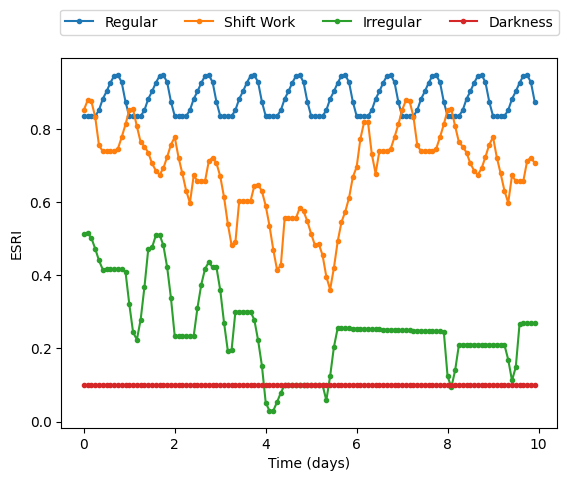

In [ ]:
#| echo: false
plt.plot(esri_time_regular/24.0, esri_array_regular, label='Regular', marker='o', markersize=3)
plt.plot(esri_time_shift/24.0, esri_array_shift, label='Shift Work', marker='o', markersize=3)
plt.plot(esri_time_irregular/24.0, esri_array_irregular, label='Irregular', marker='o', markersize=3)
plt.plot(esri_time_darkness/24.0, esri_array_darkness, label='Darkness', marker='o', markersize=3)
plt.xlabel('Time (days)')
plt.ylabel('ESRI')
# place legend at the top
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
plt.show()

This result shows the ESRI value for each start time of the analysis window. The default window length is 4 days, and the default window step is 1 hour. That's why ESRI is only calculated for half of our simulation time (8 days). In the following plot, we see that the overall ESRI value for a highly regular schedule is larger than for a random schedule, and that the ESRI value for constant darkness is 0.1 which matches the default starting amplitude for the model. Both the window length and default starting amplitude can be changed with the `analysis_days` and `initial_amplitude` parameters.

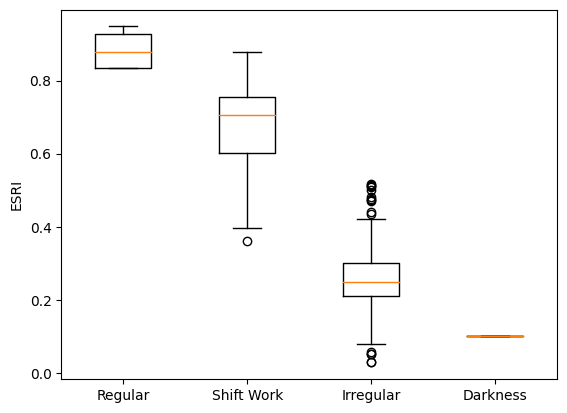

In [ ]:
#| echo: false
# create a boxplot comparing the three schedules
data = [esri_array_regular, esri_array_shift, esri_array_irregular, esri_array_darkness]
names = ['Regular', 'Shift Work', 'Irregular', 'Darkness']
plt.boxplot(data, labels=names)
plt.ylabel('ESRI')
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()